In [78]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torch.autograd import Variable

BATCH_SIZE = 16
EPOCHS = 4 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [79]:
# 读入预处理的数据
datas = np.load("./tang.npz")
data = datas['data']
ix2word = datas['ix2word'].item()
word2ix = datas['word2ix'].item()
    
# 转为torch.Tensor
data = torch.from_numpy(data)
train_loader = DataLoader(data, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

In [85]:
class PoetryModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(PoetryModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, self.hidden_dim, num_layers=3)
        self.classifier=nn.Sequential(
            nn.Linear(self.hidden_dim, 512), 
            nn.ReLU(inplace=True), 
            nn.Linear(512, 2048), 
            nn.ReLU(inplace=True),
            nn.Linear(2048, vocab_size)
        )

    def forward(self, input, hidden = None):
        seq_len, batch_size = input.size()
        
        if hidden is None:
            h_0 = input.data.new(3, batch_size, self.hidden_dim).fill_(0).float()
            c_0 = input.data.new(3, batch_size, self.hidden_dim).fill_(0).float()
        else:
            h_0, c_0 = hidden

        embeds = self.embedding(input)
        output, hidden = self.lstm(embeds, (h_0, c_0))
        output = self.classifier(output.view(seq_len * batch_size, -1))
        
        return output, hidden

In [86]:
# 配置模型，是否继续上一次的训练
model = PoetryModel(len(word2ix),embedding_dim = 128,hidden_dim = 256)

model_path = ''         # 预训练模型路径
if model_path:
    model.load_state_dict(torch.load(model_path))
model.to(DEVICE)
    
optimizer = torch.optim.Adam(model.parameters(), lr = 5e-3)
# optimizer = torch.optim.SGD(model.parameters(), lr=5e-3, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=10)

In [87]:
def train(model, dataloader, ix2word, word2ix, device, optimizer, scheduler, epoch):
    model.train()
    train_loss = 0.0
    
    for batch_idx, data in enumerate(dataloader):
        data = data.long().transpose(1, 0).contiguous()
        data = data.to(device)
        optimizer.zero_grad()
        input, target = data[:-1, :], data[1:, :]
        output, _ = model(input)
        loss = criterion(output, target.view(-1))
        loss.backward()  
        optimizer.step()
        train_loss += loss.item()
            
        if (batch_idx+1) % 200 == 0:
            print('train epoch: {} [{}/{} ({:.0f}%)]\tloss: {:.6f}'.format(
                epoch, batch_idx * len(data[1]), len(dataloader.dataset),
                100. * batch_idx / len(dataloader), loss.item()))
            
    train_loss *= BATCH_SIZE
    train_loss /= len(train_loader.dataset)
    print('\ntrain epoch: {}\t average loss: {:.6f}\n'.format(epoch,train_loss))
    scheduler.step()
    
    return train_loss

In [88]:
train_losses = []

for epoch in range(1,EPOCHS+1):
    tr_loss = train(model,train_loader,ix2word,word2ix,DEVICE,optimizer,scheduler,epoch)
    train_losses.append(tr_loss)
    
# 保存模型
filename = "model" + str(time.time()) + ".pth"
torch.save(model.state_dict(), filename) 

train epoch: 1 [3184/57580 (6%)]	loss: 2.632571
train epoch: 1 [6384/57580 (11%)]	loss: 2.861430
train epoch: 1 [9584/57580 (17%)]	loss: 2.318686
train epoch: 1 [12784/57580 (22%)]	loss: 2.628373
train epoch: 1 [15984/57580 (28%)]	loss: 2.207271
train epoch: 1 [19184/57580 (33%)]	loss: 2.214486
train epoch: 1 [22384/57580 (39%)]	loss: 2.226165
train epoch: 1 [25584/57580 (44%)]	loss: 2.536668
train epoch: 1 [28784/57580 (50%)]	loss: 2.082079
train epoch: 1 [31984/57580 (56%)]	loss: 2.794148
train epoch: 1 [35184/57580 (61%)]	loss: 1.811940
train epoch: 1 [38384/57580 (67%)]	loss: 2.114514
train epoch: 1 [41584/57580 (72%)]	loss: 2.292327
train epoch: 1 [44784/57580 (78%)]	loss: 1.911224
train epoch: 1 [47984/57580 (83%)]	loss: 2.177257
train epoch: 1 [51184/57580 (89%)]	loss: 2.128556
train epoch: 1 [54384/57580 (94%)]	loss: 2.567488

train epoch: 1	 average loss: 2.388427

train epoch: 2 [3184/57580 (6%)]	loss: 1.785987
train epoch: 2 [6384/57580 (11%)]	loss: 1.893884
train epoch: 2 [

In [89]:
# 读取模型
model_path = filename     # 模型路径
print(model_path)
model = PoetryModel(len(word2ix),embedding_dim = 128,hidden_dim = 256)
model.load_state_dict(torch.load(model_path))
model.to(DEVICE)

model1587422744.654135.pth


PoetryModel(
  (embedding): Embedding(8293, 128)
  (lstm): LSTM(128, 256, num_layers=3)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=2048, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=2048, out_features=512, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=512, out_features=8293, bias=True)
  )
)

In [90]:
def generate(model, start_words, ix2word, word2ix, max_gen_len, prefix_words=None):
    # 读取唐诗的第一句
    results = list(start_words)
    start_word_len = len(start_words)
    
    # 设置第一个词为<START>
    input = torch.Tensor([word2ix['<START>']]).view(1, 1).long()
    input = input.to(DEVICE)
    hidden = None
    
    if prefix_words:
        for word in prefix_words:
            output, hidden = model(input, hidden)
            input = Variable(input.data.new([word2ix[word]])).view(1, 1)

    # 生成唐诗
    for i in range(max_gen_len):
        output, hidden = model(input, hidden)
        # 读取第一句
        if i < start_word_len:
            w = results[i]
            input = input.data.new([word2ix[w]]).view(1, 1)
        # 生成后面的句子
        else:
            top_index = output.data[0].topk(1)[1][0].item()
            w = ix2word[top_index]
            results.append(w)
            input = input.data.new([top_index]).view(1, 1)
        # 结束标志
        if w == '<EOP>':
            del results[-1]
            break
            
    return results

In [107]:
start_words = '巴山夜雨涨秋池'  # 唐诗的第一句
max_gen_len = 128        # 生成唐诗的最长长度

prefix_words = '大漠孤烟直'
results = generate(model, start_words, ix2word, word2ix, max_gen_len, prefix_words)
poetry = ''
for word in results:
    poetry += word
    if word == '。' or word == '!':
        poetry += '\n'
        
print(poetry)

巴山夜雨涨秋池，一声千里万里流。
江南一望一千里，江上一声千万里。
江南一望一时归，江上江南一片云。
江南江上望乡路，江上月明归去时。
江南江上望江水，江上月明南浦云。
江南江上望江水，江上月明归去程。
江南江上望乡路，江上江头愁泪痕。



In [92]:
print(train_losses)

[2.388426580690766, 2.1384226280933207, 2.0583619789846987, 2.013393285167677]


In [93]:
def gen_acrostic(model, start_words, ix2word, word2ix, prefix_words=None):
    # 读取唐诗的“头”
    results = []
    start_word_len = len(start_words)
    
    # 设置第一个词为<START>
    input = (torch.Tensor([word2ix['<START>']]).view(1, 1).long())
    input = input.to(DEVICE)
    hidden = None

    index = 0            # 指示已生成了多少句
    pre_word = '<START>' # 上一个词
    
    if prefix_words:
        for word in prefix_words:
            output, hidden = model(input, hidden)
            input = Variable(input.data.new([word2ix[word]])).view(1, 1)

    # 生成藏头诗
    for i in range(max_gen_len_acrostic):
        output, hidden = model(input, hidden)
        top_index = output.data[0].topk(1)[1][0].item()
        w = ix2word[top_index]

        # 如果遇到标志一句的结尾，喂入下一个“头”
        if (pre_word in {u'。', u'！', '<START>'}):
            # 如果生成的诗已经包含全部“头”，则结束
            if index == start_word_len:
                break
            # 把“头”作为输入喂入模型
            else:
                w = start_words[index]
                index += 1
                input = (input.data.new([word2ix[w]])).view(1, 1)
                
        # 否则，把上一次预测作为下一个词输入
        else:
            input = (input.data.new([word2ix[w]])).view(1, 1)
        results.append(w)
        pre_word = w
        
    return results

In [99]:
start_words_acrostic = '深度学习'  # 唐诗的“头”
max_gen_len_acrostic = 120               # 生成唐诗的最长长度
prefix_words = None
results_acrostic = gen_acrostic(model, start_words_acrostic, ix2word, word2ix,prefix_words)

poetry = ''
for word in results_acrostic:
    poetry += word
    if word == '。' or word == '!':
        poetry += '\n'
        
print(poetry)

深山一日秋，一树一枝红。
度日不可见，一声无限情。
学人不知我，不见一时归。
习客不可见，相思不可闻。



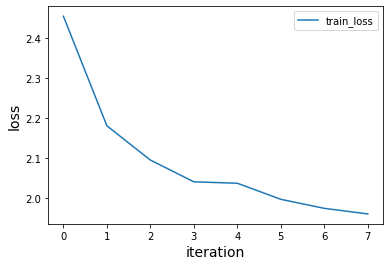

In [108]:
train_losses = [2.453792263394058, 2.1800180925433525, 2.094502791947646, 2.0401157700133514,2.036576960160526, 1.9964482630404716, 1.9738592076939234, 1.9599469747672522]
def draw_plot(data,label,x,y):
    plt.plot(data,label=label)
    plt.xlabel(x, fontsize=14)
    plt.ylabel(y, fontsize=14)
    plt.legend()
    
draw_plot(train_losses,"train_loss","iteration","loss")